# Case Study 1

#### Model selection for Clustering

Clustering is unsupervised learning: the resulting clusters are completely derived from data distributed in given a feature set with no class available

Compared to supervised learning counterparts, it is …
* hard to define model performance (cluster quality)
* sensitive to different clustering algorithms and different feature spaces.



#### Task
Your task is to try different clustering algorithms and also a range of the potential parameter(s) which affect the number of clusters including ..

* K-means
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
* Gaussian Mixture Model,
https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture
* Hierarchical Clustering,
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering
* Louvain Clustering,
https://scikit-network.readthedocs.io/en/latest/reference/clustering.html#module-sknetwork.clustering

on 5K colorectal patches represented by 4 different representation PathologyGAN, ResNet50, InceptionV3 and VGG16


#### Data and its preprocessing
5,000 non-overlapping image patches from hematoxylin & eosin (H&E) stained histological images of human colorectal cancer (CRC) and normal tissue.
* 4 feature sets, PathologyGAN, ResNet50, InceptionV3 and VGG16, are extracted to represent those 5,000 images different dimensional feature spaces.
* PCA and UMAP were employed to reduce each feature sapce into 100-dimensional vectors

* 9 tissue types are also available which include Adipose (ADI), background (BACK), debris (DEB), lymphocytes (LYM), mucus (MUC), smooth muscle (MUS), normal colon mucosa (NORM), cancer-associated stroma (STR), colorectal adenocarcinoma epithelium (TUM)


#### Performance Measurement
To assess quality of clustering solutions, several approaches are expected to be done and interpreted which include...
* Silhouette Score for goodness of fit test
* Vmeasure Score for homogeneity and completeness test (tissue type available as ground truth)
* Clusters visualisations

For more information, please have a check...
https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation


#### Report
Report on your preprocessing pipeline, theory and intuition behinds each algorithm and representation, parameter searching and performance evaluation frameworks. If there is any addiotional process, give evidences/justifications on how it helps.

#### Required Packages

In [307]:
# !pip install h5py
# !pip install numpy
# !pip install pandas
# !pip install sklearn
# !pip install scikit-network
# !pip install pickle-mixin==1.0.2
# !pip install matplotlib
# !pip install plotly


### Prepare Tissue Representations

Model, resnet50, pathologyGAN
Projection PCA, UMAP
Method KMeans, Louvain

Data            Metric
Test            Sihouette + Davies-Bouldin Index ==> need to Cross Validate to get good parameters
Label?          V-measure + Rand Index ==> show performance(model?), show similarity to test ones if YES -> we did use good parameters there

Parameters
1. k (number of cluster)

In [308]:
import h5py
import numpy as np
import pickle

In [309]:
pge_path = 'colon_nct_feature/pge_dim_reduced_feature.h5'
resnet50_path = 'colon_nct_feature/resnet50_dim_reduced_feature.h5'
inceptionv3_path = 'colon_nct_feature/inceptionv3_dim_reduced_feature.h5'
vgg16_path = 'colon_nct_feature/vgg16_dim_reduced_feature.h5'

pge_content = h5py.File(pge_path, mode='r')
resnet50_content = h5py.File(resnet50_path, mode='r')
inceptionv3_content = h5py.File(inceptionv3_path, mode='r')
vgg16_content = h5py.File(vgg16_path, mode='r')


In [310]:
vgg16_content

<HDF5 file "vgg16_dim_reduced_feature.h5" (mode r)>

In [311]:
#PCA feature from 4 feature sets: pge_latent, resnet50_latent, inceptionv3_latent, vgg16_latent
pge_pca_feature  = pge_content['pca_feature'][...]
resnet50_pca_feature  = resnet50_content['pca_feature'][...]
inceptionv3_pca_feature = inceptionv3_content['pca_feature'][...]
vgg16_pca_feature  = vgg16_content['pca_feature'][...]

In [312]:
vgg16_pca_feature

array([[ -90.864815 ,  107.03243  ,  116.16385  , ...,    8.259951 ,
          -1.1383446,   -9.175951 ],
       [ -74.06226  ,  117.31615  ,   95.24547  , ...,   -1.9739974,
           6.8172655,    4.2547903],
       [ -81.875336 ,  122.84872  ,   83.767784 , ...,   -1.3287221,
          13.65623  ,  -11.109545 ],
       ...,
       [  32.70835  ,   31.183935 ,  -47.30978  , ...,    4.2004256,
           3.599823 ,    6.0058775],
       [ -39.911785 , -105.81029  ,  122.37118  , ...,  -14.908715 ,
          -1.1814455,  -10.837135 ],
       [  32.35425  ,  -50.3373   ,   66.50197  , ...,   -3.859397 ,
          -1.047523 ,    2.3827858]], dtype=float32)

In [313]:
#UMAP feature from 4 feature sets: pge_latent, resnet50_latent, inceptionv3_latent, vgg16_latent
pge_umap_feature  = pge_content['umap_feature'][...]
resnet50_umap_feature = resnet50_content['umap_feature'][...]
inceptionv3_umap_feature  = inceptionv3_content['umap_feature'][...]
vgg16_umap_feature  = vgg16_content['umap_feature'][...]

In [314]:
#tissue type as available ground-truth: labels
filename  = np.squeeze(pge_content['file_name'])
filename = np.array([str(x) for x in filename])
labels = np.array([x.split('/')[2] for x in filename])
labels

array(['ADI', 'ADI', 'ADI', ..., 'TUM', 'TUM', 'TUM'], dtype='<U4')

# Example

In [315]:
import random

In [316]:
random.seed(0)
selected_index = random.sample(list(np.arange(len(pge_pca_feature))), 200)

In [317]:
test_data = pge_pca_feature[selected_index]
test_label = labels[selected_index]

### Exploratory Analysis

In [318]:
import plotly.graph_objects as go
import pandas as pd

In [319]:
traces = []
for name in np.unique(labels):
    trace = go.Scatter3d(
        x=test_data[test_label==name,0],
        y=test_data[test_label==name,1],
        z=test_data[test_label==name,2],
        mode='markers',
        name=name,
        marker=go.scatter3d.Marker(
            size=4,
            opacity=0.8
        )

    )
    traces.append(trace)


data = go.Data(traces)
layout = go.Layout(
            showlegend=True,
    scene=go.Scene(
                xaxis=go.layout.scene.XAxis(title='PC1'),
                yaxis=go.layout.scene.YAxis(title='PC2'),
                zaxis=go.layout.scene.ZAxis(title='PC3')
                )
)
fig = go.Figure(data=data, layout=layout)
fig.update_layout(
    title="First 3 pricipal components of PathologyGAN's PCA feature",
    legend_title="Legend Title",
)

fig.show()


/Users/jojotitichaya/Downloads/case_study_1/Case Study 1 Clustering/.venv/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:31: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.


/Users/jojotitichaya/Downloads/case_study_1/Case Study 1 Clustering/.venv/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:489: DeprecationWarning:

plotly.graph_objs.Scene is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Scene




### Model training

In [320]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sknetwork.clustering import Louvain


In [321]:
#to create Adjacency matrix for  Louvain clustering
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler


In [322]:
kmeans_model = KMeans(n_clusters = 3, random_state = 0) #GaussianMixture(), AgglomerativeClustering(), Louvain
kmeans_assignment = kmeans_model.fit_predict(test_data)

/Users/jojotitichaya/Downloads/case_study_1/Case Study 1 Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [323]:
from scipy import sparse
louvain_model = Louvain(resolution = 0.9, modularity = 'Newman',random_state = 0)
adjacency_matrix = sparse.csr_matrix(MinMaxScaler().fit_transform(-pairwise_distances(test_data)))
louvain_assignment = louvain_model.fit_predict(adjacency_matrix)

### Evaluation and Visualisation

In [324]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, v_measure_score
from sklearn.model_selection import KFold, train_test_split

* check out number of clusters/cluster assignment counts

In [325]:
print('Number of clusters from KMeans: %d and from Louvain: %d'%(np.unique(kmeans_assignment).shape[0],np.unique(louvain_assignment).shape[0]))

Number of clusters from KMeans: 3 and from Louvain: 3


In [326]:
kmeans_counts = np.unique(kmeans_assignment, return_counts = True)
louvain_counts = np.unique(louvain_assignment, return_counts = True)

In [327]:
print('Kmeans assignment counts')
pd.DataFrame({'Cluster Index': kmeans_counts[0], 'Number of members':kmeans_counts[1]}).set_index('Cluster Index')

Kmeans assignment counts


Number of members
Cluster Index                   
0                            112
1                             49
2                             39

In [328]:
print('Louvain assignment counts')
pd.DataFrame({'Cluster Index': louvain_counts[0], 'Number of members':louvain_counts[1]}).set_index('Cluster Index')

Louvain assignment counts


Number of members
Cluster Index                   
0                            132
1                             67
2                              1

* Assess goodness of fit by silhouette score and cluster homogeneities by V-measure

In [329]:
kmeans_silhouette = silhouette_score(test_data, kmeans_assignment)
louvain_silhouette = silhouette_score(test_data, louvain_assignment)
kmeans_v_measure = v_measure_score(test_label, kmeans_assignment)
louvain_v_measure = v_measure_score(test_label, louvain_assignment)
pd.DataFrame({'Metrics': ['silhouette', 'V-measure'], 'Kmeans': [kmeans_silhouette, kmeans_v_measure], 'Louvain':[louvain_silhouette, louvain_v_measure]}).set_index('Metrics')

Kmeans   Louvain
Metrics                       
silhouette  0.198873  0.246675
V-measure   0.262987  0.270140

* Visualise tissue type percentage in two different clustering configurations

In [330]:
def calculate_percent(sub_df, attrib):
    cnt = sub_df[attrib].count()
    output_sub_df = sub_df.groupby(attrib).count()
    return (output_sub_df/cnt)

/var/folders/pv/_9ndz20s1819l5gdqpjk79240000gn/T/ipykernel_9489/3428919821.py:27: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



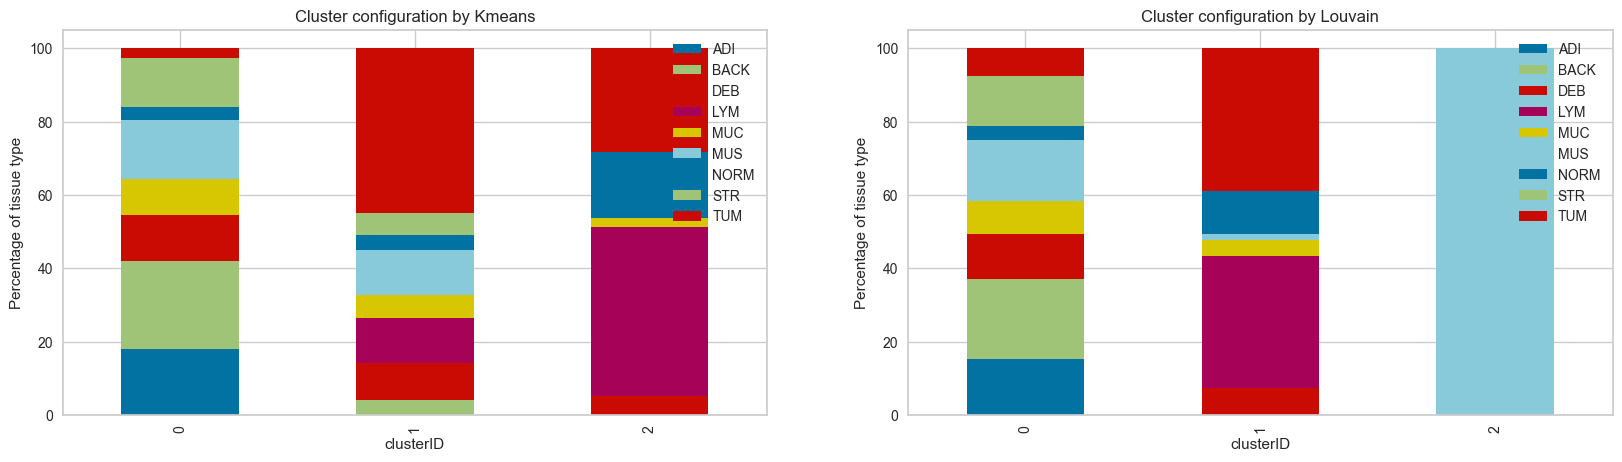

In [331]:
resulted_cluster_df = pd.DataFrame({'clusterID': kmeans_assignment, 'type': test_label})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')


f, axes = plt.subplots(1, 2, figsize=(20,5))
number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[0] )

axes[0].set_ylabel('Percentage of tissue type')
axes[0].legend(loc='upper right')
axes[0].set_title('Cluster configuration by Kmeans')

resulted_cluster_df = pd.DataFrame({'clusterID': louvain_assignment, 'type': test_label})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')


number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[1] )

axes[1].set_ylabel('Percentage of tissue type')
axes[1].legend(loc='upper right')
axes[1].set_title('Cluster configuration by Louvain')
f.show()

# Preparing the dataset for PathologyGAN (PGE) and ResNet50



In [332]:
#PCA feature from 2 feature sets: pge_latent, resnet50_latent
pge_pca_feature  = pge_content['pca_feature'][...]
resnet50_pca_feature  = resnet50_content['pca_feature'][...]

#UMAP feature from 2 feature sets: pge_latent, resnet50_latent
pge_umap_feature  = pge_content['umap_feature'][...]
resnet50_umap_feature = resnet50_content['umap_feature'][...]

#PGE test data
test_data_pge_pca = pge_pca_feature
test_data_pge_umap = pge_umap_feature

#PGE labels
filename_pge  = np.squeeze(pge_content['file_name'])
filename_pge = np.array([str(x) for x in filename_pge])
labels_pge = np.array([x.split('/')[2] for x in filename_pge])

#Resnet50 test data
test_data_resnet50_pca = resnet50_pca_feature
test_data_resnet50_umap = resnet50_umap_feature

#Resnet50 labels
filename_resnet50 = np.squeeze(resnet50_content['file_name'])
filename_resnet50 = np.array([str(x) for x in filename_resnet50])
labels_resnet50 = np.array([x.split('/')[2] for x in filename_resnet50])

# Model Training

Training the model using N=2...30 to find the optimal number of cluster using the Elbow method.

In [333]:
from sklearn.cluster import KMeans

Initializing global variable

In [334]:
seed = 2023
num_clusters = 30

Implementing a function train_squared to train clustering models and returns a list of fitted models based on the specified clustering algorithm (Model).

In [335]:
def train_squared(test_data, Model=KMeans, **param):
  model_list = []

  if Model is KMeans:
    K = list(range(2, param['n_clusters']))
    for k in K:
      # print(f"KMeans at k = {k}")
      model = Model(n_clusters=k, n_init=10, random_state=seed)
      model_list.append(model.fit(test_data))

  elif Model is AgglomerativeClustering:
    # print(param)
    
    K = list(range(2, param['n_clusters']))
    for k in K:
      # print(f"Hierachical Clustering at k = {k}")
      model = Model(n_clusters=k, metric=param['affinity'], linkage=param['linkage'])
      model_list.append(model.fit_predict(test_data))
    # print(sum_list)      
    
  elif Model is GaussianMixture:
        # Fit the Gaussian Mixture Model
        n_clusters_range = range(2, param['n_clusters'])
        for n_clusters in n_clusters_range:
          print(n_clusters)
          gmm = GaussianMixture(n_components=n_clusters)
          model_list.append(gmm.fit_predict(test_data))

  return model_list



## Initializing K-Means, Hierachical and GMM models for PGE and ResNet50

## KMeans PGE ResNet50

In [336]:
km_model_pge_pca = train_squared(test_data_pge_pca, n_clusters=num_clusters)
km_model_pge_umap = train_squared(test_data_pge_umap, n_clusters=num_clusters)

km_model_resnet_pca = train_squared(test_data_resnet50_pca, n_clusters=num_clusters)
km_model_resnet_umap = train_squared(test_data_resnet50_umap, n_clusters=num_clusters)

## Hierachical PGE ResNet50

In [337]:
hier_model_pge_pca = train_squared(test_data_pge_pca, Model=AgglomerativeClustering, n_clusters=num_clusters, affinity="euclidean", linkage="single")
hier_model_pge_umap = train_squared(test_data_pge_umap, Model=AgglomerativeClustering,  n_clusters=num_clusters, affinity="euclidean", linkage="single")

hier_model_resnet_pca = train_squared(test_data_resnet50_pca, Model=AgglomerativeClustering, n_clusters=num_clusters, affinity="euclidean", linkage="single")
hier_model_resnet_umap = train_squared(test_data_resnet50_umap, Model=AgglomerativeClustering, n_clusters=num_clusters, affinity="euclidean", linkage="single")

## Gaussian Mixture Model PGE ResNet50

In [338]:
# TODO
gmm_model_pge_pca = train_squared(test_data_pge_pca, Model=GaussianMixture, n_clusters=num_clusters)
gmm_model_pge_umap = train_squared(test_data_pge_umap, Model=GaussianMixture,  n_clusters=num_clusters)

gmm_model_resnet_pca = train_squared(test_data_resnet50_pca, Model=GaussianMixture, n_clusters=num_clusters)
gmm_model_resnet_umap = train_squared(test_data_resnet50_umap, Model=GaussianMixture, n_clusters=num_clusters)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


# Evaluation and Visualization

Importing an additional library for elbow visualization enables the determination of the optimal k value for each measurement scoring algorithm, including davies_bouldin_score, rand_score, v_measure_score, and silhouette_score.

In [339]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import davies_bouldin_score, rand_score, v_measure_score, silhouette_score

### Evaluate Model Performance

Implementing the evaluate_model function for storing scores of each metric in a dictionary called scores.

In [340]:
def evaluate_model(models, test_data, is_pge=True, m='kmean'):
    scores = []
    param = 2 ## TODO
    for model in models:
        # Example scoring criteria, you can add more as needed
        if m == 'kmean':
            model_fitted = model.predict(test_data)
        else:
            model_fitted = model
        silhouette = silhouette_score(test_data, model_fitted)
        davies_bouldin = davies_bouldin_score(test_data, model_fitted)
        if is_pge:
            rand_index = rand_score(labels_pge, model_fitted)
            v_measure = v_measure_score(labels_pge, model_fitted)
        else:
            rand_index = rand_score(labels_resnet50, model_fitted)
            v_measure = v_measure_score(labels_resnet50, model_fitted)
        

        scores.append({
            'param': param,
            'silhouette': silhouette,
            'davies_bouldin': davies_bouldin,
            'rand_index': rand_index,
            'v_measure': v_measure
        })
        param += 1

    return scores
    

### Elbow Visualization for the most optimal k

Implementing a function named elbow_visualization to determine the most optimal k, generate an elbow graph, and return the value of the optimal k along with a list of k values corresponding to Bayesian Information Criterion (BIC).

In [341]:
def elbow_visualization(test_data,Model=KMeans, visualizer = None, **param):
    #keman
    if Model is KMeans:
        visualizer = KElbowVisualizer(Model(n_init=10, random_state=seed), k=(2, param['n_clusters']))
    elif Model is AgglomerativeClustering:
        visualizer = KElbowVisualizer(Model(metric=param['affinity'], linkage=param['linkage']), k=(2, param['n_clusters']))
    elif Model is GaussianMixture:
        # visualizer = KElbowVisualizer(Model(n_components= param['n_clusters'], covariance_type='full')) -> Not support
        bic = []
        k_values = []
        lowest_bic = np.infty
        model_list = param['model_list']
        for i in range(1,len(model_list)+1):
            gmm = GaussianMixture(n_components= i)
            gmm.fit(test_data)
            k_values.append(i)
            bic.append(gmm.bic(test_data))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_components = i
        plt.plot(range(1, len(model_list)+1), bic, marker='o', color='g')
        plt.xlabel('Number of Components')
        plt.ylabel('BIC')
        plt.title('BIC for Different Numbers of Components')
        plt.axvline(x=best_components, color='r', linestyle='--', label='Best Component')
        plt.legend()
        plt.show()
        optimal_k = best_components
        elbow_scores = list(zip(k_values, bic))
        

    if visualizer:
        visualizer.fit(test_data)
        visualizer.show()
        optimal_k = visualizer.elbow_value_
        k_values = visualizer.k_values_
        k_scores = visualizer.k_scores_
        elbow_scores = list(zip(k_values, k_scores))
    return optimal_k, elbow_scores

### Visualise Scores

Implementing a function named scores_visualizer to visualize each scoring metric, including silhouette, Davies-Bouldin, Rand Index, and V-Measure score. The plots are displayed in a 4-subplot layout for the comparison of optimal k values from each metric.

In [342]:
def scores_visualizer(scores_df):
    # Data
    params = scores_df['param']
    silhouette_scores = scores_df['silhouette']
    davies_bouldin_scores = scores_df['davies_bouldin']
    rand_index_scores = scores_df['rand_index']
    v_measure_scores = scores_df['v_measure']

    # Find optimal k for each score
    best_k_silhouette = scores_df.loc[scores_df['silhouette'].idxmax()]['param']
    best_k_davies_bouldin = scores_df.loc[scores_df['davies_bouldin'].idxmin()]['param']
    best_k_rand_index = scores_df.loc[scores_df['rand_index'].idxmax()]['param']
    best_k_v_measure = scores_df.loc[scores_df['v_measure'].idxmax()]['param']

    # Visualization
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(params, silhouette_scores, marker='o')
    plt.axvline(x=best_k_silhouette, color='r', linestyle='--', label=f'Optimal K: {best_k_silhouette}')
    plt.title('Silhouette Score')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(params, davies_bouldin_scores, marker='o')
    plt.axvline(x=best_k_davies_bouldin, color='r', linestyle='--', label=f'Optimal K: {best_k_davies_bouldin}')
    plt.title('Davies-Bouldin Score')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Davies-Bouldin Score')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(params, rand_index_scores, marker='o')
    plt.axvline(x=best_k_rand_index, color='r', linestyle='--', label=f'Optimal K: {best_k_rand_index}')
    plt.title('Rand Index Score')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Rand Index Score')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(params, v_measure_scores, marker='o')
    plt.axvline(x=best_k_v_measure, color='r', linestyle='--', label=f'Optimal K: {best_k_v_measure}')
    plt.title('V-Measure Score')
    plt.xlabel('Number of Clusters')
    plt.ylabel('V-Measure Score')
    plt.legend()

    plt.tight_layout()
    plt.show()


Storing scores of each metric in a dataframe according to the model's parameters

KMeans PGE

In [343]:
scores = evaluate_model(km_model_pge_pca, test_data_pge_pca)
scores_df_km_pge_pca = pd.DataFrame(scores)

scores = evaluate_model(km_model_pge_umap, test_data_pge_umap)
scores_df_km_pge_umap = pd.DataFrame(scores)


KMeans Resnet

In [344]:
scores = evaluate_model(km_model_resnet_pca, test_data_resnet50_pca)
scores_df_km_resnet_pca = pd.DataFrame(scores)

scores = evaluate_model(km_model_resnet_umap, test_data_resnet50_umap)
scores_df_km_resnet_umap = pd.DataFrame(scores)


Hierachical PGE

In [345]:
scores = evaluate_model(hier_model_pge_pca, test_data_pge_pca, m='agglomerative')
scores_df_hier_pge_pca = pd.DataFrame(scores)

scores = evaluate_model(hier_model_pge_umap, test_data_pge_umap, m='agglomerative')
scores_df_hier_pge_umap = pd.DataFrame(scores)


Hierachical Resnet

In [346]:
scores = evaluate_model(hier_model_resnet_pca, test_data_resnet50_pca, m='agglomerative')
scores_df_hier_resnet_pca = pd.DataFrame(scores)

scores = evaluate_model(hier_model_resnet_umap, test_data_resnet50_umap, m='agglomerative')
scores_df_hier_resnet_umap = pd.DataFrame(scores)

Gaussian PGE

In [347]:
scores = evaluate_model(gmm_model_pge_pca, test_data_pge_pca, m = 'GaussianMixture')
scores_df_gmm_pge_pca = pd.DataFrame(scores)

scores = evaluate_model(gmm_model_pge_umap, test_data_pge_umap, m = 'GaussianMixture')
scores_df_gmm_pge_umap = pd.DataFrame(scores)

Gaussian Resnet

In [348]:
scores = evaluate_model(gmm_model_resnet_pca, test_data_resnet50_pca, m = 'GaussianMixture')
scores_df_gmm_resnet_pca = pd.DataFrame(scores)

scores = evaluate_model(gmm_model_resnet_umap, test_data_resnet50_umap, m = 'GaussianMixture')
scores_df_gmm_resnet_umap = pd.DataFrame(scores)

Visualizing and storing model perforamance and its optimal k

K-Means PGE PCA

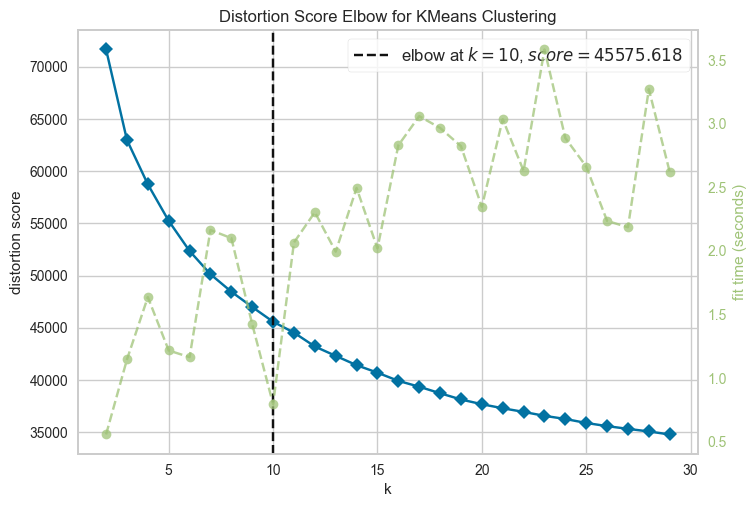

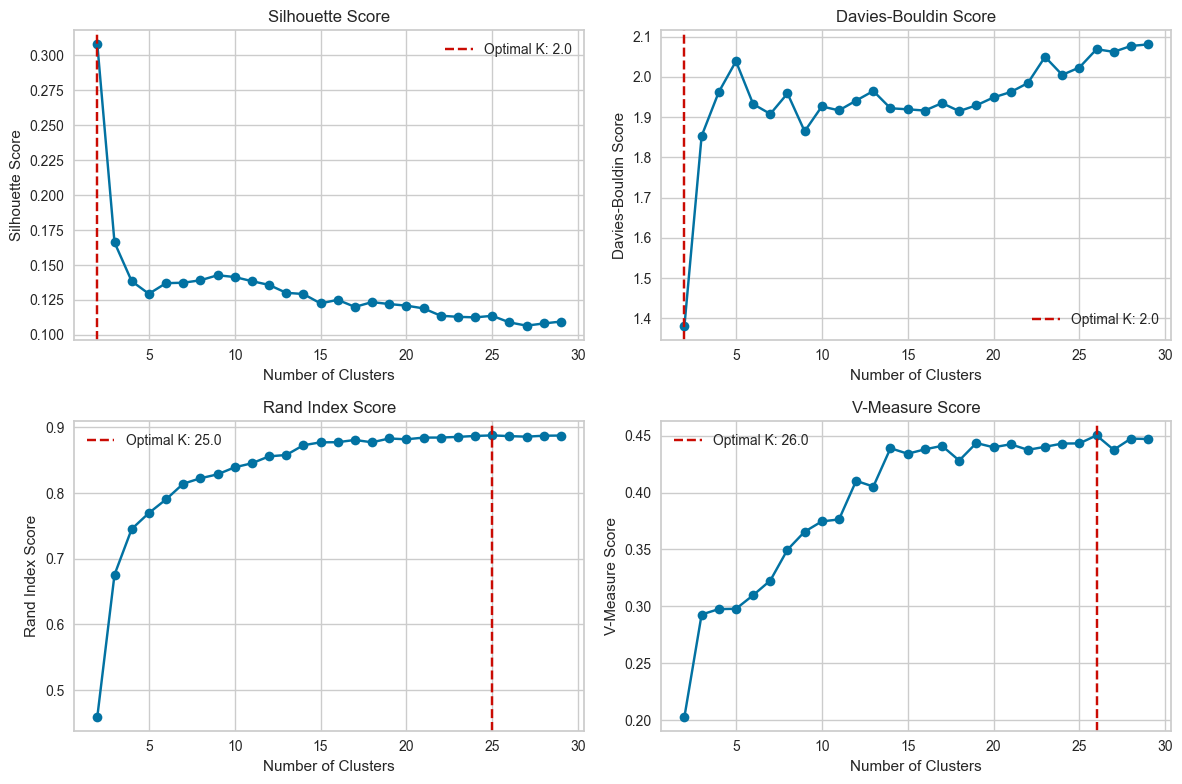

In [361]:
op_k_km_pge_pca, escores_km_pge_pca  = elbow_visualization(test_data=test_data_pge_pca,Model=KMeans, n_clusters=num_clusters)
scores_visualizer(scores_df_km_pge_pca)

K-Menas PGE UMAP

In [362]:
op_k_km_pge_umap, escores_km_pge_umap  = elbow_visualization(test_data=test_data_pge_umap,Model=KMeans, n_clusters=num_clusters)
scores_visualizer(scores_df_km_pge_umap)

K-Means ResNet50 PCA

In [ ]:
op_k_km_resnet_pca, escores_km_resnet_pca  = elbow_visualization(test_data=test_data_resnet50_pca,Model=KMeans, n_clusters=num_clusters)
scores_visualizer(scores_df_km_resnet_pca)

K-Means ResNet50 UMAP

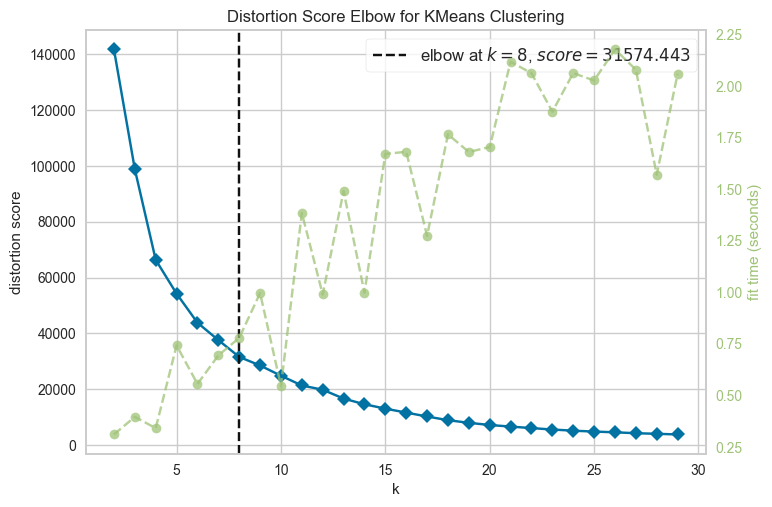

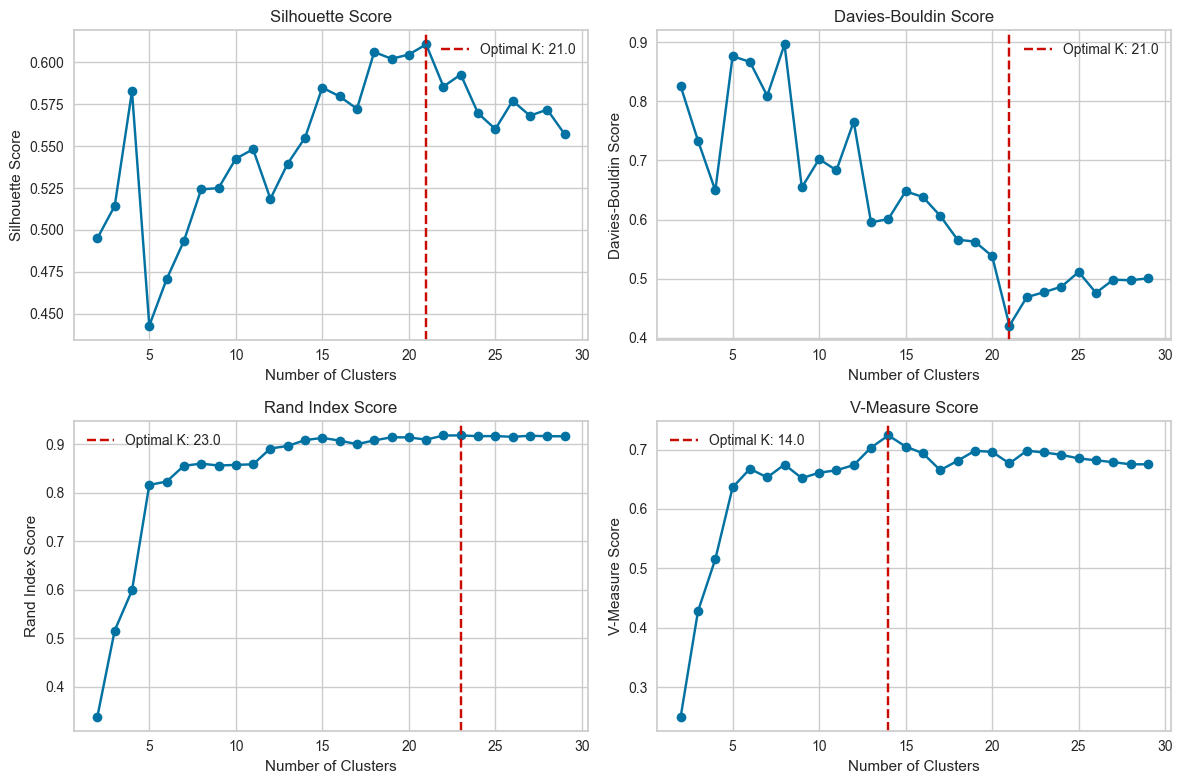

In [ ]:
op_k_km_resnet_umap, escores_km_resnet_umap  = elbow_visualization(test_data=test_data_resnet50_umap,Model=KMeans, n_clusters=num_clusters)
scores_visualizer(scores_df_km_resnet_umap)


Hierachical PGE PCA

In [ ]:
op_k_hier_pge_pca, escores_hier_pge_pca = elbow_visualization(test_data=test_data_pge_pca,Model=AgglomerativeClustering, n_clusters=num_clusters, affinity="euclidean", linkage="single")
scores_visualizer(scores_df_hier_pge_pca)

Hierachical PGE UMAP

In [ ]:
op_k_hier_pge_umap, escores_hier_pge_umap = elbow_visualization(test_data=test_data_pge_umap,Model=AgglomerativeClustering, n_clusters=num_clusters, affinity="euclidean", linkage="single")
scores_visualizer(scores_df_hier_pge_umap)

Hierachical ResNet50 PCA

In [ ]:
op_k_hier_resnet_pca, escores_hier_resnet_pca = elbow_visualization(test_data=test_data_resnet50_pca,Model=AgglomerativeClustering, n_clusters=num_clusters, affinity="euclidean", linkage="single")
scores_visualizer(scores_df_hier_resnet_pca)

Hierachical ResNet50 UMAP

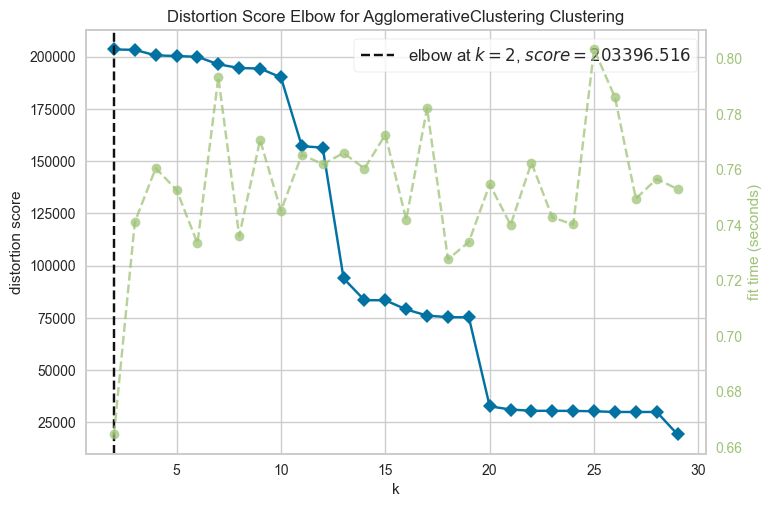

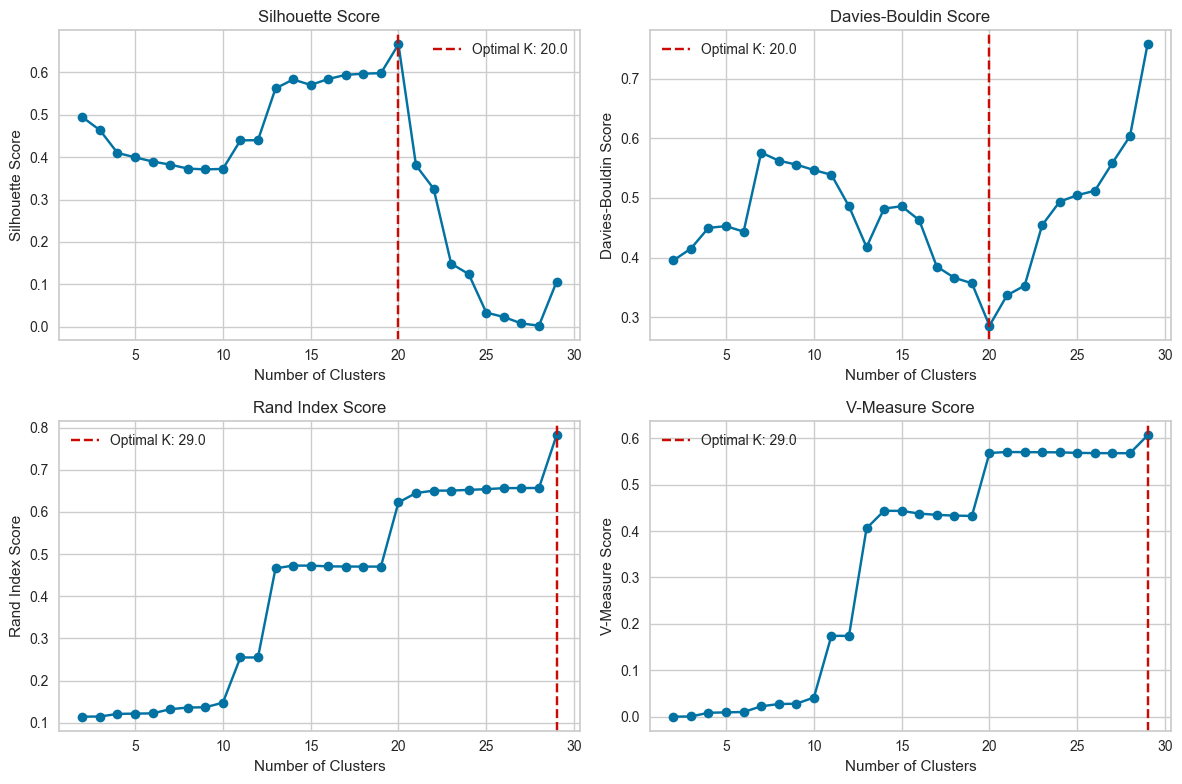

In [ ]:
op_k_hier_resnet_umap, escores_hier_resnet_umap = elbow_visualization(test_data=test_data_resnet50_umap,Model=AgglomerativeClustering, n_clusters=num_clusters, affinity="euclidean", linkage="single")
scores_visualizer(scores_df_hier_resnet_umap)


GMM PGE PCA

In [ ]:
op_k_gmm_pge_pca, escores_gmm_pge_pca = elbow_visualization(test_data=test_data_pge_pca,Model=GaussianMixture, n_clusters=num_clusters, model_list = gmm_model_pge_pca)
scores_visualizer(scores_df_gmm_pge_pca)

GMM PGE UMAP

In [ ]:
op_k_gmm_pge_umap, escores_gmm_pge_umap = elbow_visualization(test_data=test_data_pge_umap,Model=GaussianMixture, n_clusters=num_clusters, model_list = gmm_model_pge_umap)
scores_visualizer(scores_df_gmm_pge_umap)

GMM ResNet50 PCA

In [ ]:
op_k_gmm_resnet_pca, escores_gmm_resnet_pca = elbow_visualization(test_data=test_data_resnet50_pca,Model=GaussianMixture, n_clusters=num_clusters, model_list = gmm_model_resnet_pca)
scores_visualizer(scores_df_gmm_resnet_pca)

GMM ResNet50 UMAP

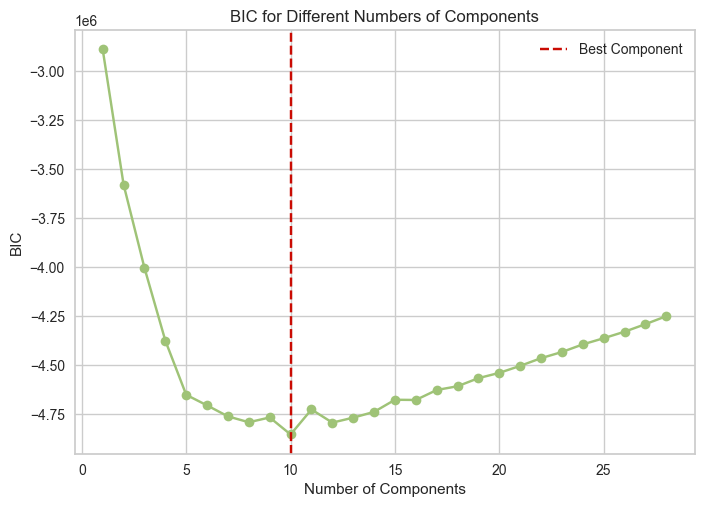

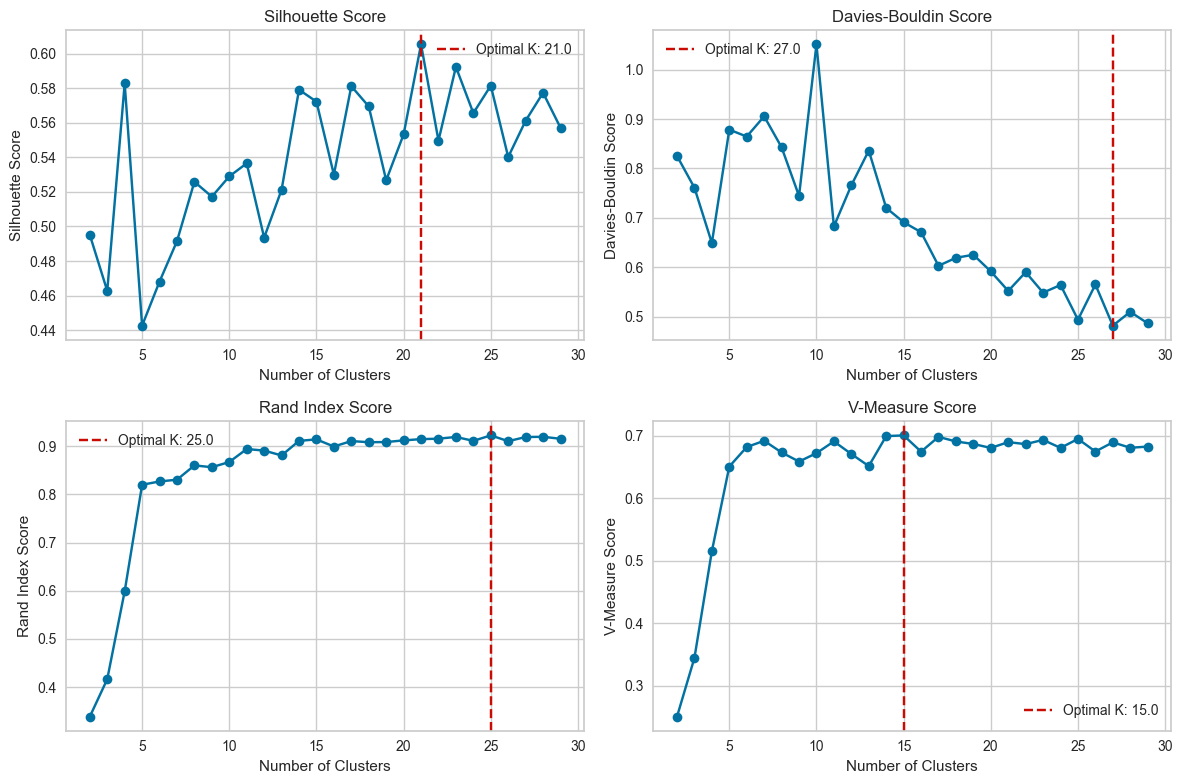

In [ ]:
op_k_gmm_resnet_umap, escores_gmm_resnet_umap = elbow_visualization(test_data=test_data_resnet50_umap,Model=GaussianMixture, n_clusters=num_clusters, model_list = gmm_model_resnet_umap)
scores_visualizer(scores_df_gmm_resnet_umap)

Implementing a function named get_optimal_k to retrieve the final optimal k by averaging the optimal k obtained from each scoring metric and the elbow method.

In [352]:
def get_optimal_k(df, elb_op_k):
    op_silhouette = int(df[df['silhouette'] == df['silhouette'].max()].param.iloc[0])
    op_davies = int(df[df['davies_bouldin'] == df['davies_bouldin'].min()].param.iloc[0])
    op_randind = int(df[df['rand_index'] == df['rand_index'].max()].param.iloc[0])
    op_vmeasure = int(df[df['v_measure'] == df['v_measure'].max()].param.iloc[0])

    return int(np.mean([elb_op_k, op_silhouette, op_davies, op_randind, op_vmeasure]))

Final Optimal k of K-Means

In [353]:
k_km_pge_pca = get_optimal_k(scores_df_km_pge_pca, op_k_km_pge_pca)
k_km_pge_umap = get_optimal_k(scores_df_km_pge_umap, op_k_km_pge_umap)
k_km_resnet_pca = get_optimal_k(scores_df_km_resnet_pca, op_k_km_resnet_pca)
k_km_resnet_umap = get_optimal_k(scores_df_km_resnet_umap, op_k_km_resnet_umap)

Final Optimal k of Hierachical Clustering

In [354]:
k_hier_pge_pca = get_optimal_k(scores_df_hier_pge_pca, op_k_hier_pge_pca)
k_hier_pge_umap = get_optimal_k(scores_df_hier_pge_umap, op_k_hier_pge_umap)
k_hier_resnet_pca = get_optimal_k(scores_df_hier_resnet_pca, op_k_hier_resnet_pca)
k_hier_resnet_umap = get_optimal_k(scores_df_hier_resnet_umap, op_k_hier_resnet_umap)

Final optimal k of Gaussian Mixture Model

In [355]:
k_gmm_pge_pca = get_optimal_k(scores_df_gmm_pge_pca, op_k_gmm_pge_pca)
k_gmm_pge_umap = get_optimal_k(scores_df_gmm_pge_umap, op_k_gmm_pge_umap)
k_gmm_resnet_pca = get_optimal_k(scores_df_gmm_resnet_pca, op_k_gmm_resnet_pca)
k_gmm_resnet_umap = get_optimal_k(scores_df_gmm_resnet_umap, op_k_gmm_resnet_umap)

# Cluster Visualization

In [356]:
import plotly.graph_objects as go
from sklearn.decomposition import PCA

Implementing a function named cluster_visualization to visualize clusters using the final optimal k value.

In [357]:
def cluster_visualization(test_data, k, model_list, name):

    if "K-Means" in name:
        labels = (model_list[k-2]).labels_
    elif "Hierachical" in name or "Gaussian" in name:
        labels = (model_list[k-2])
    
    cluster_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for _ in range(len(np.unique(labels)))]

    # PCA
    pca_scaled_std = PCA(n_components=3, random_state=seed)
    X_pca_3d = pca_scaled_std.fit_transform(test_data)

    # Create a Plotly 3D Scatter plot
    traces = []
    for l, c in zip(range(0, np.max(labels) + 1), cluster_colors[0:np.max(labels) + 1]):
        trace = go.Scatter3d(
            x=X_pca_3d[labels == l, 0],
            y=X_pca_3d[labels == l, 1],
            z=X_pca_3d[labels == l, 2],
            mode='markers',
            name=f'cluster {l}',
            marker=dict(size=4, opacity=0.8, color=c),
        )
        traces.append(trace)

    layout = go.Layout(
        title="3D PCA Visualization" + name,
        scene=dict(
            xaxis=dict(title='Principal Component 1'),
            yaxis=dict(title='Principal Component 2'),
            zaxis=dict(title='Principal Component 3'),
        ),
    )

    fig = go.Figure(data=traces, layout=layout)

    fig.show()


K-Means cluster visualization

In [358]:
cluster_visualization(test_data_pge_pca, k_km_pge_pca, km_model_pge_pca, "K-Means Pathology PCA")
cluster_visualization(test_data_pge_umap, k_km_pge_umap, km_model_pge_umap, "K-Means Pathology UMAP")
cluster_visualization(test_data_resnet50_pca, k_km_resnet_pca, km_model_resnet_pca, "K-Means ResNet50 PCA")
cluster_visualization(test_data_resnet50_umap, k_km_resnet_umap, km_model_resnet_umap, "K-Means ResNet50 UMAP")

Hierachical cluster visualization

In [359]:
cluster_visualization(test_data_pge_pca, op_k_hier_pge_pca, hier_model_pge_pca, "Hierachical Pathology PCA")
cluster_visualization(test_data_pge_umap, op_k_hier_pge_umap, hier_model_pge_umap, "Hierachical Pathology UMAP")
cluster_visualization(test_data_resnet50_pca, op_k_hier_resnet_pca, hier_model_resnet_pca, "Hierachical ResNet50 PCA")
cluster_visualization(test_data_resnet50_umap, op_k_hier_resnet_umap, hier_model_resnet_umap, "Hierachical ResNet50 UMAP")

GaussianMixture cluster visualization

In [360]:
cluster_visualization(test_data_pge_pca, op_k_gmm_pge_pca, gmm_model_pge_pca, "GaussianMixture Pathology PCA")
cluster_visualization(test_data_pge_umap, op_k_gmm_pge_umap, gmm_model_pge_umap, "GaussianMixture Pathology UMAP")
cluster_visualization(test_data_resnet50_pca, op_k_gmm_resnet_pca, gmm_model_resnet_pca, "GaussianMixture ResNet50 PCA")
cluster_visualization(test_data_resnet50_umap, op_k_gmm_resnet_umap, gmm_model_resnet_umap, "GaussianMixture ResNet50 UMAP")